In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import corner
import jax.numpy as jnp
from opt_einsum import contract
from jax.config import config
import jax
config.update("jax_enable_x64", True)

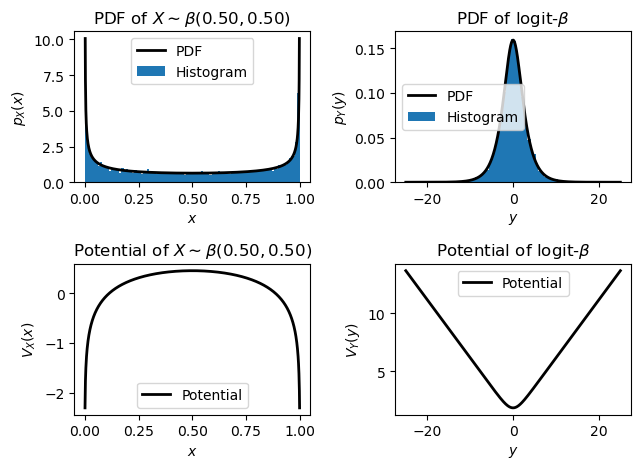

In [2]:
""" 
References
----------

(1) https://stats.stackexchange.com/questions/286042/derivation-of-the-mean-and-variance-of-the-logit-transform-of-a-beta-random-vari

"""

# Define a beta distributed random variable
alpha = 0.5
beta = 0.5
rv = scipy.stats.beta(alpha, beta)
beta_samples = rv.rvs(size=10000)

# Definitions needed for transformationj
B = scipy.special.beta(alpha, beta) # Normalization constant
logit = lambda x: jnp.log(x / (1 - x))
logistic_CDF = lambda x: 1 / (1 + jnp.exp(-x))
logistic_PDF = lambda x: jnp.exp(-x) / (1 + jnp.exp(-x)) ** 2
logit_beta_pdf = lambda x: (1/B) * logistic_CDF(x) ** alpha * (1 - logistic_CDF(x)) ** beta
logit_beta_samples = logit(beta_samples)

# Plot the PDF of the beta rv and its histogram
fig, ax = plt.subplots(2,2)
x = np.linspace(0, 1, 1000)
beta_pdf_values = rv.pdf(x)
ax[0, 0].plot(x, beta_pdf_values, 'k-', lw=2, label='PDF')
ax[0, 0].hist(beta_samples, density=True, bins=100, label='Histogram')
ax[0, 0].set_xlabel(r'$x$')
ax[0, 0].set_ylabel(r'$p_X(x)$')
ax[0, 0].set_title(r'PDF of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[0, 0].legend()

# Plot the potential of the beta rv
beta_potential_values = -np.log(beta_pdf_values)
ax[1, 0].plot(x, beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 0].set_xlabel(r'$x$')
ax[1, 0].set_ylabel(r'$V_X(x)$')
ax[1, 0].set_title(r'Potential of $X \sim \beta(%.2f, %.2f)$' % (alpha, beta))
ax[1, 0].legend()

# Plot the PDF of the logit(beta) rv and its histogram
y = np.linspace(-25, 25, 1000);
logit_beta_pdf_values = logit_beta_pdf(y)
ax[0, 1].plot(y, logit_beta_pdf_values, 'k-', lw=2, label='PDF');
ax[0, 1].hist(logit_beta_samples, density=True, bins=100, label='Histogram');
ax[0, 1].set_title(r'PDF of logit-$\beta$')
ax[0, 1].set_xlabel(r'$y$')
ax[0, 1].set_ylabel(r'$p_Y(y)$')
ax[0, 1].legend()

# Plot the potential of the PDF
ax[1, 1].set_xlabel(r'$y$')
ax[1, 1].set_ylabel(r'$V_Y(y)$')
ax[1, 1].set_title(r'Potential of logit-$\beta$')
logit_beta_potential_values = -np.log(logit_beta_pdf(y))
ax[1, 1].plot(y, logit_beta_potential_values, 'k-', lw=2, label='Potential')
ax[1, 1].legend()

plt.tight_layout()

# Testing

In [35]:
logit = lambda x: jnp.log(x / (1 - x))
logistic_CDF = lambda x: 1 / (1 + jnp.exp(-x))
logistic_PDF = lambda x: jnp.exp(-x) / (1 + jnp.exp(-x)) ** 2
sigma_inv = lambda x, a, b: (x - a) / (b - a)

def reparameterization(X, V_X, grad_V_X, hess_V_X, a, b): 
    d = len(a)

    # Transform from hypercube to unit sphere 
    delta = b - a
    V_Z = V_X - jnp.sum(np.log(delta))
    grad_V_Z = grad_V_X * delta[np.newaxis, ...]
    hess_V_Z = hess_V_X * np.outer(delta, delta)[np.newaxis, ...]

    # Transform from unit cube to R^d
    Y = logit(sigma_inv(X, a, b))
    f = logistic_PDF(Y)
    F = logistic_CDF(Y)

    V_Y = V_Z - jnp.sum(np.log(f), axis=1)
    
    grad_V_Y = grad_V_Z * f + 2 * F - 1
    
    hess_V_Y = hess_V_Z * (f[:, :, np.newaxis] * f[:, np.newaxis, :]) 
    hess_V_Y = hess_V_Y.at[:, jnp.arange(d), jnp.arange(d)].add(2 * f)
    hess_V_Y = hess_V_Y.at[:, jnp.arange(d), jnp.arange(d)].add(grad_V_Z * f * (1 - 2 * F))

    return Y, V_Y, grad_V_Y, hess_V_Y


In [36]:
x = jnp.array([0.5])[..., np.newaxis]

# Beta distribution parameters
alpha = 0.5
beta = 0.5

# Bounds
a = jnp.array([0.])
b = jnp.array([1.])

# Calculation over x with JAX
beta_pdf = lambda x: jax.scipy.stats.beta.pdf(x, alpha, beta)
V_x = lambda x: -1 * jnp.log(beta_pdf(x)).squeeze()
grad_V_x = lambda x: jax.vmap(jax.jacfwd(V_x))(x)
hess_V_x = lambda x: jax.vmap(jax.jacfwd(jax.jacrev(V_x)))(x)

# Calculation over y with JAX
B = scipy.special.beta(alpha, beta) # Normalization constant
logit_beta_pdf = lambda x: ((1/B) * logistic_CDF(x) ** alpha * (1 - logistic_CDF(x)) ** beta).squeeze()
V_y = lambda y: -1 * jnp.log(logit_beta_pdf(y)).squeeze()
grad_V_y = lambda y: jax.vmap(jax.jacfwd(V_y))(y)
hess_V_y = lambda y: jax.vmap(jax.jacfwd(jax.jacrev(V_y)))(y)

# Analytical transformation 
x = np.linspace(0.001, 0.99, 1000)[..., np.newaxis] # Avoid drawing points too close to the boundary for numerical stability
y = logit(x)
grad_V_x__ = grad_V_x(x)
y, v, gv, hv = reparameterization(x, V_x(x), grad_V_x(x), hess_V_x(x), a, b)

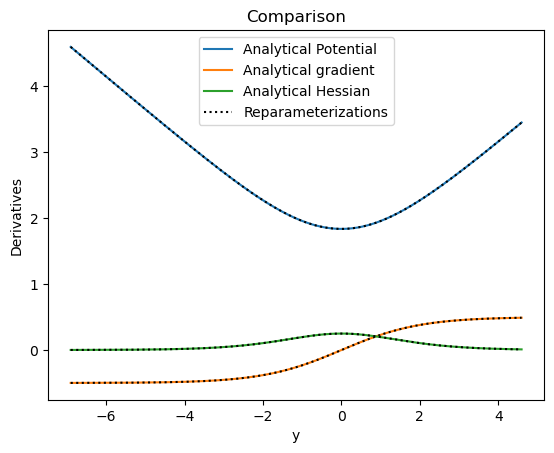

In [41]:
fig5, ax5 = plt.subplots()

ax5.plot(y, -np.log(logit_beta_pdf(y)), label='Analytical Potential')
ax5.plot(y, v, linestyle='dotted', c='k')

ax5.plot(y, grad_V_y(y), label='Analytical gradient')
ax5.plot(y, gv, linestyle='dotted', c='k')

ax5.plot(y, hess_V_y(y).squeeze(), label='Analytical Hessian')
ax5.plot(y, hv.squeeze(), linestyle='dotted', c='k', label='Reparameterizations')

ax5.set_title('Comparison')
ax5.set_xlabel('y')
ax5.set_ylabel('Derivatives')
ax5.legend()